## Original functions from Lucy

In [1]:
def MinimumSkew(genome):
   skew = Skew(genome)
   value = min(skew.values())
   minimum = []
   for i in skew:
       if skew[i] == value:
           minimum.append(i)
   return minimum

In [2]:
def Skew(Genome):
   array = {}
   n = len(Genome)
   array[0] = 0
   for i in range(len(Genome)):
       array[i+1] = array[i]
       if Genome[i] == 'C':
           array[i+1] = array[i+1]-1
       if Genome[i] == 'G':
           array[i+1] = array[i+1]+1
   return array

## Reimplementation using numpy

In [3]:
import numpy as np
from random import choice

In [124]:
def min_skew(genome):
    # convert sequence to a numpy array of chars and return a view of char codes
    aseq = np.array(list(genome), dtype=np.dtype('S1')).view(np.int8)

    # cumulative sums of 'G' and 'C' bases in the sequence
    g_cum_sum = np.cumsum(aseq == ord('G'), dtype=np.int64)
    c_cum_sum = np.cumsum(aseq == ord('C'), dtype=np.int64)
    
    # skew is the difference of the two sums
    skews = g_cum_sum - c_cum_sum
    
    # get the minimum skew from skews
    min_skew = skews.min()
    # if it is not negative, set it to 0
    min_skew = min_skew if min_skew < 0 else 0
    
    # return the (1-based) indices of all the minimum values in skews
    return np.where(skews == min_skew)[0] + 1


In [125]:
%prun min_skew(test_genome)

In [91]:
def py_min_skew(genome):
    gs, cs, min_skew = 0, 0, 0
    indices = []
    for i, base in enumerate(genome, 1):
        if base == 'G':
            gs += 1
        elif base == 'C':
            cs += 1
        skew = gs - cs
        if skew < min_skew:
            min_skew = skew
            indices = [i]
        elif skew == min_skew:
            indices.append(i)
    return indices

In [115]:
%timeit py_min_skew(test_genome)

1 loop, best of 3: 1.31 s per loop


## Reimplementation using Cython

In [69]:
%load_ext Cython

In [122]:
%%cython
def cy_min_skew(str genome):
    cdef longgs = 0
    cs = 0
    min_skew = 0
    indices = [0]
    for i, base in enumerate(genome, 1):
        if base == 'G':
            gs += 1
        elif base == 'C':
            cs += 1
        skew = gs - cs
        if skew < min_skew:
            min_skew = skew
            indices = [i]
        elif skew == min_skew:
            indices.append(i)
    return indices

In [123]:
%timeit cy_min_skew(test_genome)

1 loop, best of 3: 565 ms per loop


In [35]:
tg = build_random_genome(10)

In [107]:
%timeit min_skew(test_genome)

1 loop, best of 3: 365 ms per loop


In [5]:
# decorator that generates a random genome sequence of length SIZE
def with_random_genome(func):
    def func_wrapper(size):
        genome = build_random_genome(size)
        return func(genome)
    return func_wrapper

In [6]:
def build_random_genome(size):
    bases = ['A', 'C', 'G', 'T']
    genome = [choice(bases) for _ in range(size)]
    return "".join(genome)

## testing the two approaches give the same result

In [62]:
# generate test genome of 65000 lines * 80 chars per line
test_genome = build_random_genome(65000*80)

In [28]:
len(test_genome)

5200000

In [29]:
65000*80

5200000

In [8]:
min_skew(test_genome)

array([2515774])

In [9]:
MinimumSkew(test_genome)

[2515774]

## Time complexity analysis

### utility functions

In [10]:
from timeit import timeit, repeat
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [11]:
def time_function(name, arg, n=1):
    f = lambda x: name + '(' + str(x) + ')'
    g = globals()
    
    time = timeit(f(arg), globals=g, number=n)
    return time/n

In [12]:
def get_times(name, xs, n=5):
    f = lambda x: name + '(' + str(x) + ')'
    g = globals()
    
    samples = []
    for _ in range(n):
        times = lambda x: repeat(f(x), globals=g, number=1, repeat=n)
        samples.append([np.median(times(x)) for x in xs])
    ys = [np.median(sample) for sample in zip(*samples)]
    
    return ys

In [13]:
def my_plotter(ax, x_data, y_data, param_dict={}):
    out = ax.plot(x_data, y_data, **param_dict)
    return out

### the numpy-based approach is 10 times faster

In [14]:
# time in seconds to get minimum skew of the test sequence using Lucy's code
time_function('MinimumSkew', 'test_genome')

2.9824265479983296

In [15]:
# and now using the numpy-based code
time_function('min_skew', 'test_genome')

0.369592298000498

In [16]:
# range of genome lengths to generate
genome_sizes = range(20, 1000)

In [17]:
# higher-order functions that take a genome size instead of the actual genome sequence
min_skew_with_genome_size = with_random_genome(min_skew)
min_skew_lucy_with_genome_size = with_random_genome(MinimumSkew)

In [18]:
# get run times for each genome length
times_lucy = get_times('min_skew_lucy_with_genome_size', genome_sizes)
times_numpy = get_times('min_skew_with_genome_size', genome_sizes)

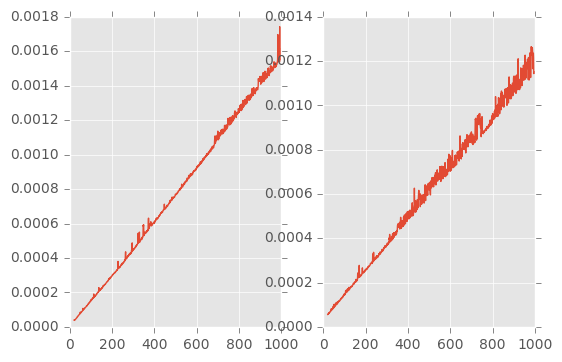

In [19]:
# plot the results
fig, (ax1, ax2) = plt.subplots(1, 2)
my_plotter(ax1, genome_sizes, times_lucy)
my_plotter(ax2, genome_sizes, times_numpy)

In [20]:
# both approaches are O(n), ie. linear, in time

## Memory complexity analysis

In [21]:
from memory_profiler import memory_usage

In [22]:
def get_mem_usage(name, xs):
    
    ys = []
    for x in xs:
        genome = build_random_genome(int(x))
        def foo():
            return name(genome)
        ys.append(max(memory_usage(foo)))
  
    return ys

In [23]:
# range of genome lengths to generate
genome_sizes = [1e7]

In [24]:
# get memory usage for each genome length
mem_lucy = get_mem_usage(MinimumSkew, genome_sizes)
mem_numpy = get_mem_usage(min_skew, genome_sizes)

In [25]:
mem_lucy

[973.1953125]

In [26]:
mem_numpy

[299.9296875]

In [27]:
# ~3 times less memory consumption with the numpy code

In [30]:
%load_ext memory_profiler

In [32]:
%memit np.zeros(int(1e7))

peak memory: 129.06 MiB, increment: 0.00 MiB


In [33]:
%memit MinimumSkew(test_genome)

peak memory: 554.71 MiB, increment: 425.66 MiB


In [34]:
%memit min_skew(test_genome)

peak memory: 196.24 MiB, increment: 53.90 MiB


In [151]:
def skew_numpy(genome):
    # convert sequence to a numpy array of chars and return a view of char codes
    #aseq = np.array(list(genome), dtype=np.dtype('S1')).view(np.int8)
    aseq = np.frombuffer(genome, dtype=np.dtype('S1')).view(np.int8)

    # cumulative sums of 'G' and 'C' bases in the sequence
    dt = np.int32 if len(genome) < 2**32 -1 else np.int64
    g_cum_sum = np.cumsum(aseq == ord('G'), dtype=dt)
    c_cum_sum = np.cumsum(aseq == ord('C'), dtype=dt)
    
    # skew is the difference of the two sums
    skews = g_cum_sum
    skews -= c_cum_sum
    
    # get the minimum skew from skews
    min_skew = skews.min()
    # if it is not negative, set it to 0
    min_skew = min_skew if min_skew < 0 else 0
    
    # return the indices of all the minimum values in skews, shifted by 1
    return np.where(skews == min_skew)[0] + 1

In [130]:
if 0:
    gen = np.random.randint(0, 4, size=5200000)
    genome = ''
    for g in gen:
        if g == 0:
            genome += 'T'
        if g == 1:
            genome += 'G'
        if g == 2:
            genome += 'A'
        if g == 3:
            genome += 'C'

    with open('f', 'w') as f:
        f.write(genome)
else:
    with open('f', 'rb') as f:
        genome = f.read()

FileNotFoundError: [Errno 2] No such file or directory: 'f'

In [131]:
gen = np.random.randint(0, 4, size=5200000)
genome = ''
for g in gen:
    if g == 0:
        genome += 'T'
    if g == 1:
        genome += 'G'
    if g == 2:
        genome += 'A'
    if g == 3:
        genome += 'C'

with open('f', 'w') as f:
    f.write(genome)

In [132]:
with open('f', 'rb') as f:
    genome = f.read()

In [133]:
%timeit skew_numpy(genome)

10 loops, best of 3: 84.1 ms per loop


In [135]:
type(genome)

bytes

In [138]:
MinimumSkew(genome)

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [139]:
%memit skew_numpy(genome)

peak memory: 672.64 MiB, increment: 60.14 MiB


In [140]:
%memit genome

peak memory: 608.53 MiB, increment: 0.00 MiB


In [143]:
type(genome.decode())

str

In [146]:
%timeit MinimumSkew(genome.decode())

1 loop, best of 3: 3.05 s per loop


In [147]:
%timeit skew_numpy(genome)

10 loops, best of 3: 83.2 ms per loop
